<a href="https://colab.research.google.com/github/robinrb7/RealWorldSizing/blob/main/DPT_depth_sizing2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Install necessary libraries (run this in a Colab cell)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install transformers
!pip install pillow requests supervision exifread

Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
!pip uninstall torch torchvision torchaudio -y

Found existing installation: torch 2.6.0+cu118
Uninstalling torch-2.6.0+cu118:
  Successfully uninstalled torch-2.6.0+cu118
Found existing installation: torchvision 0.21.0+cu118
Uninstalling torchvision-0.21.0+cu118:
  Successfully uninstalled torchvision-0.21.0+cu118
Found existing installation: torchaudio 2.6.0+cu118
Uninstalling torchaudio-2.6.0+cu118:
  Successfully uninstalled torchaudio-2.6.0+cu118


In [3]:
# Install PyTorch with CUDA 11.8
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.6.0%2Bcu118-cp311-cp311-linux_x86_64.whl.metadata (27 kB)
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.21.0%2Bcu118-cp311-cp311-linux_x86_64.whl.metadata (6.1 kB)
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.6.0%2Bcu118-cp311-cp311-linux_x86_64.whl.metadata (6.6 kB)
Using cached https://download.pytorch.org/whl/cu118/torch-2.6.0%2Bcu118-cp311-cp311-linux_x86_64.whl (848.7 MB)
Using cached https://download.pytorch.org/whl/cu118/torchvision-0.21.0%2Bcu118-cp311-cp311-linux_x86_64.whl (6.5 MB)
Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.6.0%2Bcu118-cp311-cp311-linux_x86_64.whl (3.3 MB)


In [4]:
# Step 2: Import Libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import requests
import supervision as sv
import exifread

# Hugging Face Transformers
from transformers import (
    AutoProcessor, AutoModelForZeroShotObjectDetection,
    SamModel, SamProcessor, AutoImageProcessor, AutoModelForDepthEstimation
)

In [5]:
# Step 3: Load Models

# Grounding DINO
model_id = "IDEA-Research/grounding-dino-base"
processor = AutoProcessor.from_pretrained(model_id)
detection_model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to("cuda")

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


In [6]:
# Segment Anything Model (SAM)
sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
sam_model = SamModel.from_pretrained("facebook/sam-vit-base").to("cuda")

In [7]:
# Depth Estimation with DPT-Large (NYU Depth V2)
depth_model_id = "Intel/dpt-large"  # Using DPT-Large fine-tuned on NYU Depth V2
depth_processor = AutoImageProcessor.from_pretrained(depth_model_id)
depth_model = AutoModelForDepthEstimation.from_pretrained(depth_model_id).to("cuda")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# Step 4: Load and Process Image

# Load image
image_path = "/content/ex4.jpg"
image = Image.open(image_path)

In [9]:
# Define text prompt
text_prompt = "a bottle. a cup."  # Replace with your object description

# Preprocess image and text prompt
inputs = processor(images=image, text=text_prompt, return_tensors="pt").to("cuda")

# Run Grounding DINO
with torch.no_grad():
    outputs = detection_model(**inputs)

# Post-process results
target_sizes = [image.size[::-1]]  # (height, width)
results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.27,
    text_threshold=0.35,
    target_sizes=target_sizes
)

In [10]:
# Extract bounding boxes, labels, and scores
boxes = results[0]["boxes"].cpu().numpy()
labels = results[0]["labels"]
scores = results[0]["scores"].cpu().numpy()

In [11]:
# Step 5: Segment Objects Using SAM

def calculate_pixel_dimensions(mask):
    """Calculate the actual pixel width and height of the segmented object from the mask."""
    if mask.ndim == 3:  # If mask is 3D, take the first channel
        mask = mask[0]

    y_indices, x_indices = np.where(mask > 0)  # Get object pixel locations

    if len(y_indices) == 0 or len(x_indices) == 0:
        return 0, 0  # No object detected

    height = np.max(y_indices) - np.min(y_indices) + 1
    width = np.max(x_indices) - np.min(x_indices) + 1

    return width, height

In [12]:
# Store pixel dimensions
object_pixel_dimensions = []

Object 1 (a bottle): Width = 557 px, Height = 2128 px


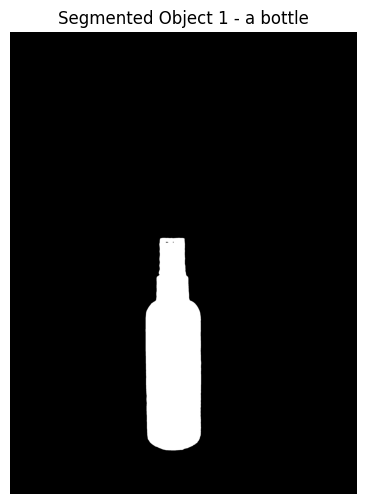

In [13]:
# Process each detected object
for idx, (box, label, score) in enumerate(zip(boxes, labels, scores)):
    if score > 0.25:  # Confidence threshold
        x_min, y_min, x_max, y_max = box

        # Use the bounding box center as the input point for SAM
        input_points = [[[(x_min + x_max) / 2, (y_min + y_max) / 2]]]

        # Prepare inputs for SAM
        inputs_sam = sam_processor(
            image,
            input_points=input_points,
            return_tensors="pt"
        ).to("cuda")

        # Run SAM
        with torch.no_grad():
            outputs_sam = sam_model(**inputs_sam)

        # Post-process SAM masks
        masks = sam_processor.image_processor.post_process_masks(
            outputs_sam.pred_masks.cpu(),
            inputs_sam["original_sizes"].cpu(),
            inputs_sam["reshaped_input_sizes"].cpu(),
        )

        # Extract first mask
        mask = masks[0][0, 0].cpu().numpy()  # Ensure correct shape

        # Calculate pixel width and height of the actual object
        width, height = calculate_pixel_dimensions(mask)
        object_pixel_dimensions.append((width, height))

        # Display results
        print(f"Object {idx + 1} ({label}): Width = {width} px, Height = {height} px")

        # Visualize the mask
        plt.figure(figsize=(6, 6))
        plt.imshow(mask, cmap="gray")
        plt.title(f"Segmented Object {idx + 1} - {label}")
        plt.axis("off")
        plt.show()


In [14]:
# Step 6: Estimate Depth Using DPT-Large (NYU Depth V2)
inputs_depth = depth_processor(images=image, return_tensors="pt").to("cuda")

with torch.no_grad():
    outputs_depth = depth_model(**inputs_depth)
    predicted_depth = outputs_depth.predicted_depth

# Resize depth map to match original image
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

In [15]:
depth_map = prediction.squeeze().cpu().numpy()

In [16]:
# Normalize depth values (NYU Depth V2 is in meters)
depth_map = depth_map / depth_map.max()

In [17]:
# Store estimated depths
estimated_depths = []

In [18]:
# Extract depth for each detected object using segmentation mask
for idx, (box, label, score) in enumerate(zip(boxes, labels, scores)):
    if score > 0.25:
        mask = masks[0][0].cpu().numpy()
        if mask.ndim == 3:  # Ensure mask is 2D
            mask = mask[0]

        object_depths = depth_map[mask > 0]  # Select only the depths where the object is detected

        if object_depths.size > 0:
            median_depth = np.median(object_depths)  # Use median to reduce noise
        else:
            median_depth = 0  # Default to zero if no depth values found

        estimated_depths.append(median_depth)
        print(f"Object {idx + 1} ({label}): Estimated Depth = {median_depth:.2f} meters")

Object 1 (a bottle): Estimated Depth = 0.81 meters


In [19]:
# Step 7: Extract Focal Length from Image Metadata

def get_focal_length(image_path):
    with open(image_path, "rb") as f:
        tags = exifread.process_file(f)

    focal_length = tags.get("EXIF FocalLength", "N/A")
    if focal_length != "N/A":
        focal_length = focal_length.values[0].num / focal_length.values[0].den
    return focal_length

In [20]:
# Get and print focal length
focal_length = get_focal_length(image_path)
print(f"📷 Focal Length: {focal_length} mm")

📷 Focal Length: 4.74 mm


In [28]:
def convert_focal_length_to_pixels(focal_length_mm, image_width, sensor_width=8.4):
    return (focal_length_mm * image_width) / sensor_width

In [29]:
focal_length_px = convert_focal_length_to_pixels(
    focal_length_mm=focal_length,
    image_width=image.size[0]
)

In [30]:
print(f"📷 Focal Length in Pixels: {focal_length_px:.2f} px")

📷 Focal Length in Pixels: 1959.20 px


In [31]:
# Function to calculate real-world object size
def calculate_real_world_size(pixel_size, depth, focal_length_px):
    """
    Convert object pixel size to real-world size using pinhole camera model.

    :param pixel_size: Width or height of the object in pixels
    :param depth: Estimated depth of the object in meters
    :param focal_length_px: Focal length in pixels
    :return: Real-world size in meters
    """
    return (pixel_size * depth) / focal_length_px

In [32]:
# Store real-world dimensions
real_world_sizes = []

In [33]:
# Calculate real-world sizes for each detected object
for idx, ((pixel_width, pixel_height), depth, label) in enumerate(zip(object_pixel_dimensions, estimated_depths, labels)):
    real_width = calculate_real_world_size(pixel_width, depth, focal_length_px)
    real_height = calculate_real_world_size(pixel_height, depth, focal_length_px)

    real_world_sizes.append((real_width, real_height))

    print(f"📏 Object {idx + 1} ({label}):")
    print(f"   - Real Width: {real_width:.2f} meters")
    print(f"   - Real Height: {real_height:.2f} meters")

📏 Object 1 (a bottle):
   - Real Width: 0.23 meters
   - Real Height: 0.88 meters
